# Predict Customer Satisfaction - XGBoost

## Introduction

In this activity, I’ll build on the skills and techniques you learned in the decision tree and random forest lessons to construct an XGBoost classification model.

This activity is a continuation of the airlines project in which I have built decision tree and random forest models. I will use the same data, but this time I will train, tune, and evaluate an XGBoost model. I’ll then compare the performance of all three models and decide which model is best. Finally, you’ll explore the feature importances of my model and identify the features that most contribute to customer satisfaction.

## Import relevant packages

In [1]:
# Import relevant libraries and modules.

import numpy as np
import pandas as pd
import matplotlib as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from xgboost import XGBClassifier
from xgboost import plot_importance

## Load the dataset

In [3]:
airline_data = pd.read_csv('Data//Invistico_Airline.csv')
airline_data.head(10)


,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,...,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,...,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,...,2,2,2,4,5,3,4,2,30,26.0


### Display the data type for each column

In [4]:
# Display the data type for each column in your DataFrame.
airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj

**Question:** Identify the target (or predicted) variable for passenger satisfaction. What is your initial hypothesis about which variables will be valuable in predicting satisfaction?

- `satisfaction` represents the classification variable to be predicted.
- Many of these variables seem like meaningful predictors of satisfaction. In particular, delays (either departure or arrival) may be negatively correlated with satisfaction.

## Data preparation

**Question:** Which metrics are most suited to evaluating this type of model?

- As this is a binary classfication problem, it will be important to evaluate not just accuracy, but the balance of false positives and false negatives that the model's predictions provide. Therefore, precision, recall, and ultimately the F1 score will be excellent metrics to use.
- The ROC AUC (Area Under the Receiver Operating Characteristic) score is also suited to this type of modeling.

### Variable encoding

In [5]:
# Convert the object predictor variables to numerical dummies.

airline_data_dummies = pd.get_dummies(airline_data, 
                                         columns=['satisfaction','Customer Type','Type of Travel','Class'])

### Isolate target and predictor variables

In [6]:
y = airline_data_dummies['satisfaction_satisfied']
X = airline_data_dummies.drop(['satisfaction_satisfied','satisfaction_dissatisfied'], axis = 1)

### Divide your data 

In [7]:
# Perform the split operation on your data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Model building

### Instantiate XGBClassifer

In [8]:
# Define xgb to be your XGBClassifier.
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

### Define the parameters for hyperparameter tuning

To identify suitable parameters for your `xgboost` model, first define the parameters for hyperparameter tuning. Specifically, define a range of values for `max_depth`, `min_child_weight`, `learning_rate`, `n_estimators`, `subsample`, and `colsample_bytree`.

Consider a more limited range for each parameter to allow for timely iteration and model training.

In [9]:
# Define parameters for tuning as `cv_params`.
cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

**Question:** What is the likely effect of adding more estimators to your GridSearch?

- More estimators will initially improve the model's performance. However, increasing the number of estimators will also considerably increase the time spent during the GridSearch process, and there will be diminishing returns as the number of estimators continues to increase.

### Define how the models will be evaluated

Define how the models will be evaluated for hyperparameter tuning. To yield the best understanding of model performance, utilize a suite of metrics.

In [11]:
# Define your criteria as `scoring`.
scoring = ['accuracy', 'precision', 'recall', 'f1']

### Construct the GridSearch cross-validation 

Construct the GridSearch cross-validation using the model, parameters, and scoring metrics you defined. Additionally, define the number of folds and specify *which metric* from above will guide the refit strategy.

In [12]:
# Construct your GridSearch.
xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring = scoring,
                      cv = 5,
                      refit = 'f1'
                     )

### Fit the GridSearch model to your training data

If your GridSearch takes too long, revisit the parameter ranges above and consider narrowing the range and reducing the number of estimators.

**Note:** The following cell might take several minutes to run.

In [13]:
%%time
# fit the GridSearch model to training data

xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

CPU times: total: 4min 5s
Wall time: 1min 9s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [14]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7}

**Question:** Which optimal set of parameters did the GridSearch yield?

Through accessing the `best_params_` attribute of the fitted GridSearch model, the optimal set of hyperparameters was:
```{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7} ```

### Save your model for reference using `pickle`

In [13]:
# Use `pickle` to save the trained model.

# pickle.dump(xgb_cv, open('xgb_cv.sav', 'wb'))

## Results and evaluation

### Formulate predictions on your test set

In [16]:
# Apply your model to predict on your test data. Call this output "y_pred".
y_pred = xgb_cv.predict(X_test)

### Leverage metrics to evaluate your model's performance

In [17]:
# 1. Print your accuracy score.
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

# 2. Print your precision score.
pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

# 3. Print your recall score.
rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

# 4. Print your f1 score.
f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.9346165691407453
precision score: 0.9471708842763719
recall score: 0.9331092436974789
f1 score: 0.9400874841258643


**Question:** How should you interpret your accuracy score?

The accuracy score for this model is 0.939, or 93.9% accurate.

**Question:** Is your accuracy score alone sufficient to evaluate your model?

In classification problems, accuracy is useful to know but may not be the best metric to evaluate this model.

**Question:** When observing the precision and recall scores of your model, how do you interpret these values, and is one more accurate than the other?

Precision and recall scores are both useful to evaluate the correct predictive capability of the model because they balance the false positives and false negatives inherent in prediction. The model shows a precision score of 0.948, suggesting the model is very good at predicting true positives. This means the model correctly predicts whether the airline passenger will be satisfied. The recall score of 0.940 is also very good. This means that the model does a good job of correctly identifying dissatisfied passengers within the dataset. These two metrics combined give a better assessment of model performance than the accuracy metric does alone.

**Question:** What does your model's F1 score tell you, beyond what the other metrics provide?*

The F1 score balances the precision and recall performance to give a combined assessment of how well this model delivers predictions. In this case, the F1 score is 0.944, which suggests very strong predictive power in this model.

### Gain clarity with the confusion matrix

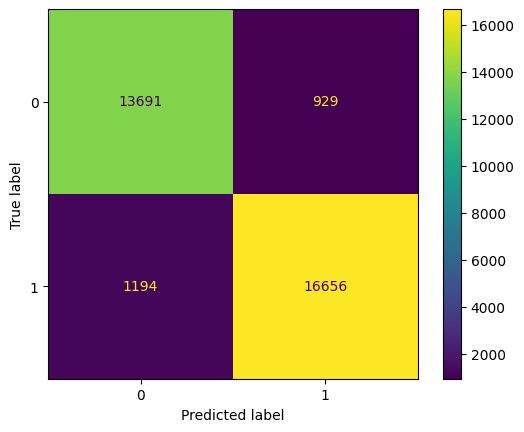

In [18]:
# Construct and display your confusion matrix.

cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)
disp.plot()

**Question:** When observing your confusion matrix, what do you notice? Does this correlate to any of your other calculations?

The top left to bottom right diagonal in the confusion matrix represents the correct predictions, and the ratio of these squares showcases the accuracy.

Additionally, the concentration of true positives and true negatives stands out relative to false positives and false negatives, respectively. This ratio is why the precision score is so high (0.944).

### Visualize most important features

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

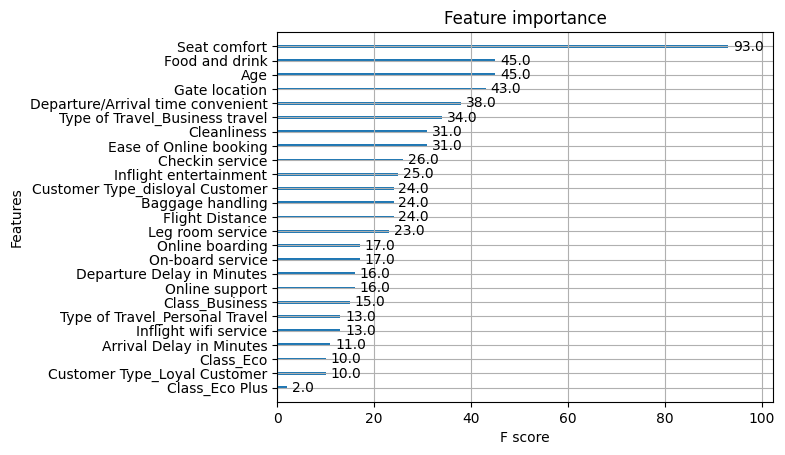

In [19]:
# Plot the relative feature importance of the predictor variables in your model.
plot_importance(xgb_cv.best_estimator_)

**Question:** Examine the feature importances outputted above. What is your assessment of the result? Did anything surprise you?

- By a wide margin, "seat comfort" rated as most important in the model.The type of seating is very different between first class and coach seating. However, the perks of being in first class also go beyond the seating type, so perhaps that is an underlying explanation of this feature's importance.
- Surprisingly, delays (both arrival and departure) did not score as highly important.



### Compare models

Create a table of results to compare model performance.

In [20]:
# Create a table of results to compare model performance.

### YOUR CODE HERE ###

tree = pd.Series({'F1':  0.945422,
                'Recall': 0.935863,
                'Precision': 0.955197,
                'Accuracy': 0.940864})
                      
forest = pd.Series({'F1':  0.947306,
                        'Recall': 0.944501,
                        'Precision': 0.950128,
                        'Accuracy': 0.942450
                      })

xgboost = pd.Series({   'F1':  f1_score,
                        'Recall': rc_score,
                        'Precision': pc_score,
                        'Accuracy': ac_score})
table = pd.DataFrame({'Decision Tree':tree, 'Random Forest':forest, 'XGBoost':xgboost})
table


,Decision Tree,Random Forest,XGBoost
F1,0.945422,0.947306,0.940087
Recall,0.935863,0.944501,0.933109
Precision,0.955197,0.950128,0.947171
Accuracy,0.940864,0.942450,0.934617


**Question:** How does this model compare to the decision tree and random forest models you built in previous labs? 

Based on the results shown in the table above, the F1, precision, recall, and accuracy scores of the XGBoost model are similar to the corresponding scores of the decision tree and random forest models. The random forest model seemed to outperform the decision tree model as well as the XGBoost model. 

## Considerations

**What are some key takeaways you learned from this lab?**
- The evaluation of the model is important to inform if the model has delivered accurate predictions.
- Splitting the data is important for ensuring that there is new data for the model to test its predictive performance.
- Each metric provides an evaluation from a different standpoint, and accuracy alone is not a strong way to evaluate a model.
- Effective assessments balance the true/false positives versus true/false negatives through the confusion matrix and F1 score.

**How would you share your findings with your team?**
- Showcase the data used to create the prediction and the performance of the model overall.
- Review the sample output of the features and the confusion matrix to reference the model's performance.
- Highlight the metric values, emphasizing the F1 score.
- Visualize the feature importance to showcase what drove the model's predictions.

**What would you share with and recommend to stakeholders?**
- The model created is highly effective at predicting passenger satisfaction.
- The feature importance of seat comfort warrants additional investigation. It will be important to ask domain experts why they believe this feature scores so highly in this model.